### 数据集

In [57]:
import os

import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from geo import get_classified_dataset, get_dataset_geo_feature
from app_utils import dataset_compress
import utils
import network


print(torch.__version__)
try:
    num_gpus = torch.cuda.device_count()
    current_gpu_index = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_gpu_index)
    print(gpu_name)
except:
    print('no gpu')

2.0.1+cu117
NVIDIA GeForce RTX 3050 Laptop GPU


In [58]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, '..', 'dataset')
results_dir = os.path.join(cwd, 'results')
print(dataset_dir, results_dir)
utils.set_seed(42)

/home/hhw/geo/hhw_code/../dataset /home/hhw/geo/hhw_code/results
Set seed 42


#### 加载数据集

In [59]:
dataset_name = 'mnist'
trans = transforms.Compose([
    transforms.ToTensor()
    ])

mnist_trainset = torchvision.datasets.MNIST(
    root=dataset_dir, train = True, download = False, transform = trans)

mnist_testset = torchvision.datasets.MNIST(
    root = dataset_dir, train = False, download = False, transform = trans)


#### 截取部分数据做测试

In [60]:
train_size = 5000
k = 16

In [61]:
origin_train_size = 60000

In [62]:
sample_index = np.random.choice(range(origin_train_size), train_size, replace=False)

mnist_data_arr = mnist_trainset.data.numpy()[sample_index]
mnist_label_arr = mnist_trainset.targets.numpy()[sample_index]

mnist_data_arr = mnist_data_arr.reshape(train_size, -1)

# 将数据分类存放
classified_dataset = get_classified_dataset(mnist_data_arr, mnist_label_arr)

In [63]:
# 获取训练集 几何特征
each_class_feature, egr_scope, uhop_scope = get_dataset_geo_feature(classified_dataset, k=k)

In [64]:
# save to file
# import pickle
# geo_feature_path = os.path.join(
#     results_dir, f"geo_{dataset_name}_trsz{train_size}_k{k}.pkl"
# )
# with open(geo_feature_path, "wb") as f:
#     pickle.dump(each_class_feature, f)
#     pickle.dump(egr_scope, f)
#     pickle.dump(uhop_scope, f)
# # read from file
# with open(geo_feature_path, 'rb') as f:
#     each_class_feature = pickle.load(f)
#     egr_scope = pickle.load(f)
#     uhop_scope = pickle.load(f)

#### 数据压缩/增强

In [65]:
# 获取 egr, uhop 阈值
# egr_threshold = (egr_scope[0] + egr_scope[1]) / 2.0
# uhop_threshold = (uhop_scope[0] + uhop_scope[1]) / 2.0

rate = 0.3
egr_threshold = egr_scope[1] - (egr_scope[1] - egr_scope[0]) * rate
uhop_threshold = uhop_scope[1] - (uhop_scope[1] - uhop_scope[0]) * rate
egr_threshold, uhop_threshold

(0.7517673953804246, 0.0006649149782298373)

In [66]:
res_data_dict, removed_data_dict = dataset_compress(classified_dataset = classified_dataset,
                                                    each_class_feature = each_class_feature,
                                                    rate = rate, 
                                                    egr_threshold = egr_threshold, 
                                                    uhop_threshold = uhop_threshold)

#### 测试数据压缩/增强的效果

In [67]:
import torch.utils.data as torch_data
res_train_X = np.concatenate([res_data_dict[label] for label in res_data_dict.keys()]).reshape(-1, 1, 28, 28).astype(np.float32)
res_train_y = np.concatenate([np.ones(res_data_dict[label].shape[0]) * label for label in res_data_dict.keys()]).astype(np.int64)
res_train_dataset = torch_data.TensorDataset(torch.from_numpy(res_train_X), torch.from_numpy(res_train_y))

batch_size = 64

res_train_iter = torch_data.DataLoader(res_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_iter = torch_data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)


In [68]:
res_size = int((1 - rate) * train_size)
random_idxs = np.random.choice(train_size, res_size, replace=False)
bench_data_arr = mnist_data_arr[random_idxs].reshape(-1, 1, 28, 28).astype(np.float32)
bench_label_arr = mnist_label_arr[random_idxs].astype(np.int64)

bench_train_dataset = torch_data.TensorDataset(torch.from_numpy(bench_data_arr), torch.from_numpy(bench_label_arr))
bench_train_iter = torch_data.DataLoader(bench_train_dataset, batch_size=batch_size, shuffle=True)


In [69]:
mnist_train_dataset = torch_data.TensorDataset(torch.from_numpy(mnist_data_arr.reshape(-1, 1, 28, 28).astype(np.float32)), torch.from_numpy(mnist_label_arr.astype(np.int64)))
mnist_train_iter = torch_data.DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)

In [70]:
# for X, y in res_train_iter:
#     print("res_iter", X.shape, y.shape)
#     print(f"type: X: {X.dtype}, y: {y.dtype}")
#     break
# for X, y in mnist_test_iter:
#     print("test_iter", X.shape, y.shape)
#     print(f"type: X: {X.dtype}, y: {y.dtype}")
#     break
bench_data_arr.shape

(3500, 1, 28, 28)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

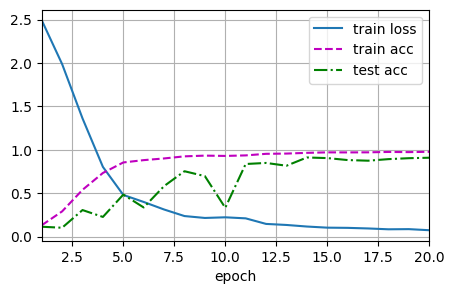

In [71]:
from network import LeNet, train
lr, num_epochs = 0.9, 20

# 在小数据上压缩后训练 (train_size * (1-rate))
net = LeNet
train(net, res_train_iter, mnist_test_iter, num_epochs, lr, device = utils.try_gpu())


Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

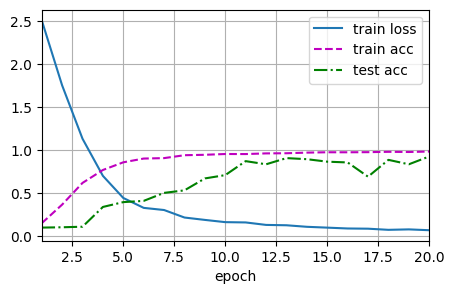

In [72]:
# 在小数据集上随机选取相同数量的样本，与压缩算法的结果进行对比 (train_size * (1-rate))
bench_net = LeNet
train(bench_net, bench_train_iter, mnist_test_iter, num_epochs, lr, device=utils.try_gpu(0))

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

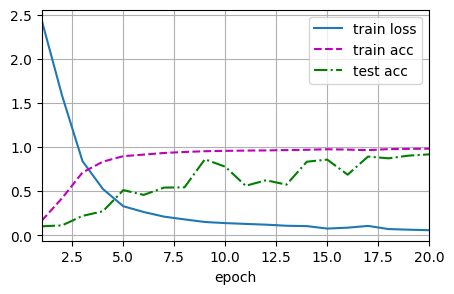

In [73]:
# 在小数据集上直接训练：train_size
mnist_net = LeNet
train(mnist_net, mnist_train_iter, mnist_test_iter, num_epochs, lr, device=utils.try_gpu(0))

In [74]:
def set_seed(seed: int):
    torch.manual_seed(seed) # 为CPU设置随机种子
    torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU，为所有GPU设置随机种子
    # np.random.seed(seed) # Numpy module.
    # random.seed(seed) # Python random module.
set_seed(42)

In [75]:
origin_lenet = network.train(origin_lenet, origin_train_iter, test_iter, num_epochs, lr, device)

NameError: name 'origin_lenet' is not defined

In [ ]:
res_lenet = network.train(res_lenet, res_train_iter, test_iter, num_epochs, lr, device)


#### 其他

In [ ]:
a1 = torch.tensor([[-1.0356,  2.0356]])
a1.fill_diagonal_(fill_value=0)

In [ ]:
# Python program explaining
# where() function

import numpy as np

# a is an array of integers.
a = np.array([[1, 0, 3], [4, 5, 6]])

print(a)

print ('Indices of elements <4')

b = np.where(a == 0, 11, a)
print(b)




In [ ]:

from torch import nn
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        # print(self.shape)
        return x.reshape(self.shape)

net = nn.Sequential(
    Reshape(-1, 1, 28, 28),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid()
)
X = torch.tensor([])
for X, y in origin_train_iter:
    print(X.shape)
    print(y.shape)

In [ ]:
a = X.reshape((-1, 1, 28, 28))
a.shape
print(X.shape)
b = net(X)
print(b.shape)